<a href="https://colab.research.google.com/github/EmmaKLofthouse/vegetable_identifier/blob/basic_cnn/basic_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


# VegNet: Neural Network Vegetable Classifier

> This notebook contains code for the development of a basic CNN from scratch.


# Table of Contents

...

# Introduction

In this project, we utilize deep learning, particularly convolutional neural networks (CNNs), to automatically identify different types of vegetables from images. By leveraging a diverse training dataset collected from google images and CNN architectures, our model learns to discern intricate features and patterns, enabling precise vegetable classification. With applications ranging from optimizing inventory management to aiding in crop monitoring, our work aims to streamline processes and enhance efficiency in agriculture and culinary domains.

After downloading, cleaning and organising the image files (see data_cleaning.ipynb), we now begin the model building by creating a simple CNN using TensorFlow.

# Load modules

In [ ]:
!pip3 install split_folders

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import numpy as np
import splitfolders


RANDOM_STATE = 42

# Save independent test sample

In [ ]:
raw_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/raw_images'
output = "/content/drive/MyDrive/Projects/vegetable_identifier/"
splitfolders.ratio(raw_dir, output=output, seed=42, ratio=(0.9,0.1))

# Load data into keras

In [3]:
test_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/test/'
test = tf.keras.utils.image_dataset_from_directory(test_dir)

Found 139 files belonging to 8 classes.


In [4]:
train_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/train'
data = tf.keras.utils.image_dataset_from_directory(train_dir)

Found 1206 files belonging to 8 classes.


# Pre-process Data

In [5]:
# Scale the pixel data to between 0 and 1
data = data.map(lambda x,y: (x/255.,y))

### Split data into training and validation samples

In [6]:
# Split into train, validation and test samples
n_batchs = len(data)
train_size = int(n_batchs*0.8)
val_size = int(n_batchs*0.2)

# if rounding causes sizes to be less than amount of data, add spare data to the training set
total_size = train_size+val_size
if total_size < n_batchs:
  train_size += n_batchs - total_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

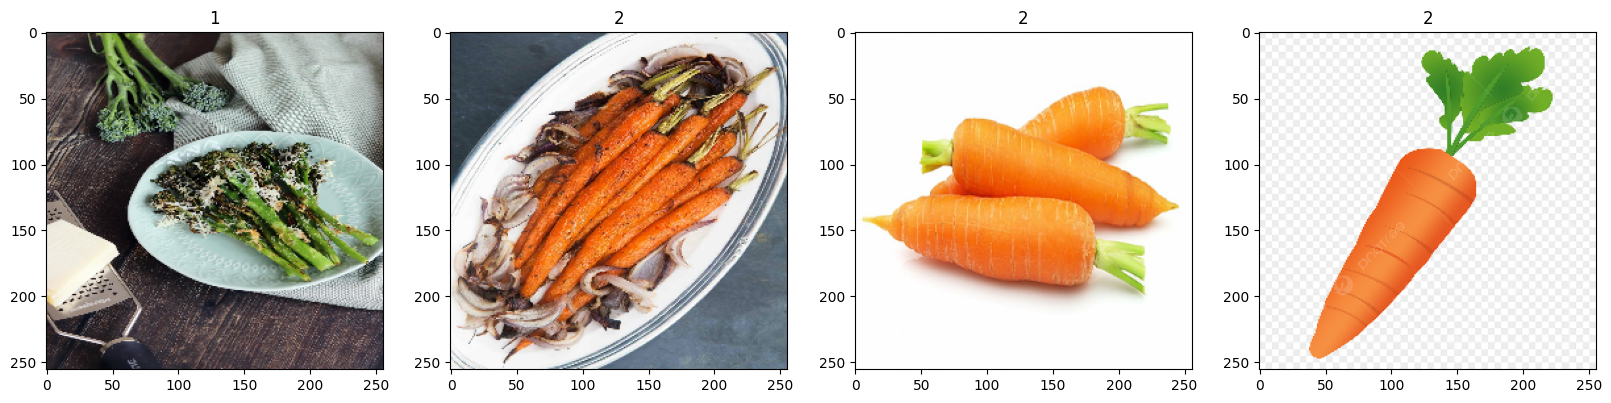

In [7]:
train_iterator = train.as_numpy_iterator()
batch = train_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [9]:
# Numerical Labels are determined alphabetically, therefore the labels are as follows:
categories = os.listdir(train_dir)
categories.sort()

for i, category in enumerate(categories):
  print(f"Class {i} is {category}")

Class 0 is bell_pepper
Class 1 is broccoli
Class 2 is carrot
Class 3 is lettuce
Class 4 is mushroom
Class 5 is onion
Class 6 is peas
Class 7 is tomato


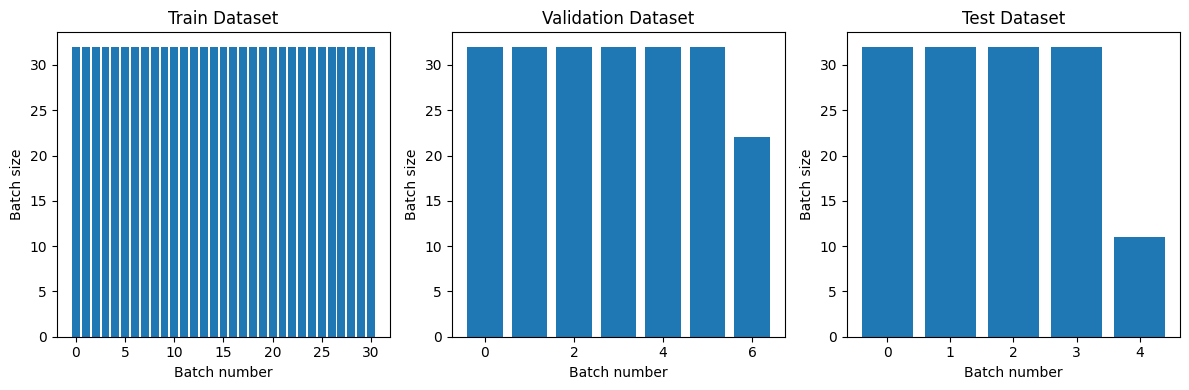

In [10]:
def plot_batch_sizes(ds, subplot_title):
    batch_sizes = [batch[0].shape[0] for batch in ds]
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    plt.title(subplot_title)
    plt.bar(range(len(batch_sizes)), batch_sizes)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plot_batch_sizes(train, 'Train Dataset')

plt.subplot(1, 3, 2)
plot_batch_sizes(val, 'Validation Dataset')

plt.subplot(1, 3, 3)
plot_batch_sizes(test, 'Test Dataset')

plt.tight_layout()
plt.show()

# Build a simple CNN

In [12]:
def create_simple_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (256,256, 3)  # Shape of processed images
num_classes = len(categories)  # Number of vegetable categories

# Create the CNN model
model = create_simple_cnn(input_shape, num_classes)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [14]:
# Compile the model
model.compile(optimizer=Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model

In [15]:
log_dir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [16]:
hist= model.fit(train,
                epochs=20,
                validation_data=val,
                callbacks=[tensorboard_callback])

Epoch 1/20
31/31 [==============================] - 110s 3s/step - loss: 1.6628 - accuracy: 0.3296 - val_loss: 1.3692 - val_accuracy: 0.4346
Epoch 2/20
31/31 [==============================] - 115s 4s/step - loss: 1.3219 - accuracy: 0.4879 - val_loss: 1.2590 - val_accuracy: 0.5467
Epoch 3/20
31/31 [==============================] - 114s 4s/step - loss: 1.0240 - accuracy: 0.6270 - val_loss: 1.0137 - val_accuracy: 0.6308
Epoch 4/20
31/31 [==============================] - 117s 4s/step - loss: 0.8064 - accuracy: 0.6996 - val_loss: 0.7787 - val_accuracy: 0.7336
Epoch 5/20
31/31 [==============================] - 115s 4s/step - loss: 0.6140 - accuracy: 0.7833 - val_loss: 0.7357 - val_accuracy: 0.7150
Epoch 6/20
31/31 [==============================] - 104s 3s/step - loss: 0.4578 - accuracy: 0.8438 - val_loss: 0.4672 - val_accuracy: 0.8271
Epoch 7/20
31/31 [==============================] - 97s 3s/step - loss: 0.3002 - accuracy: 0.9042 - val_loss: 0.3289 - val_accuracy: 0.9019
Epoch 8/20
31/

# plot performance


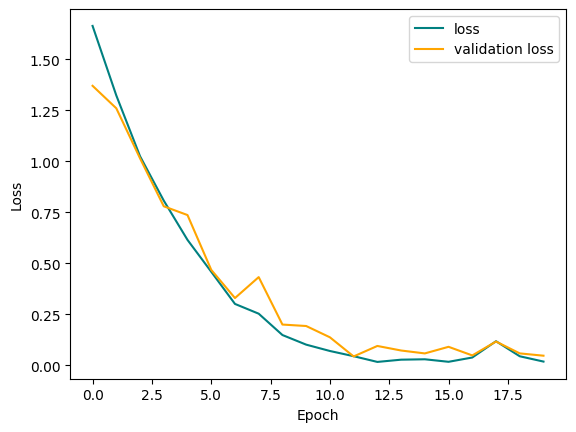

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Accuracy

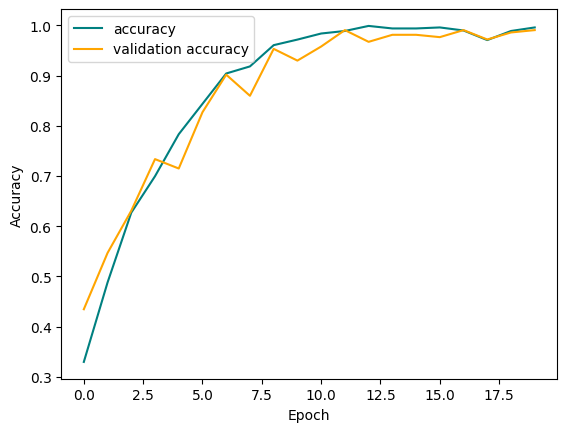

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='validation accuracy')
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Evaluate the model performance

Found 139 files belonging to 8 classes.
1/1 [==============================] - 1s 774ms/step


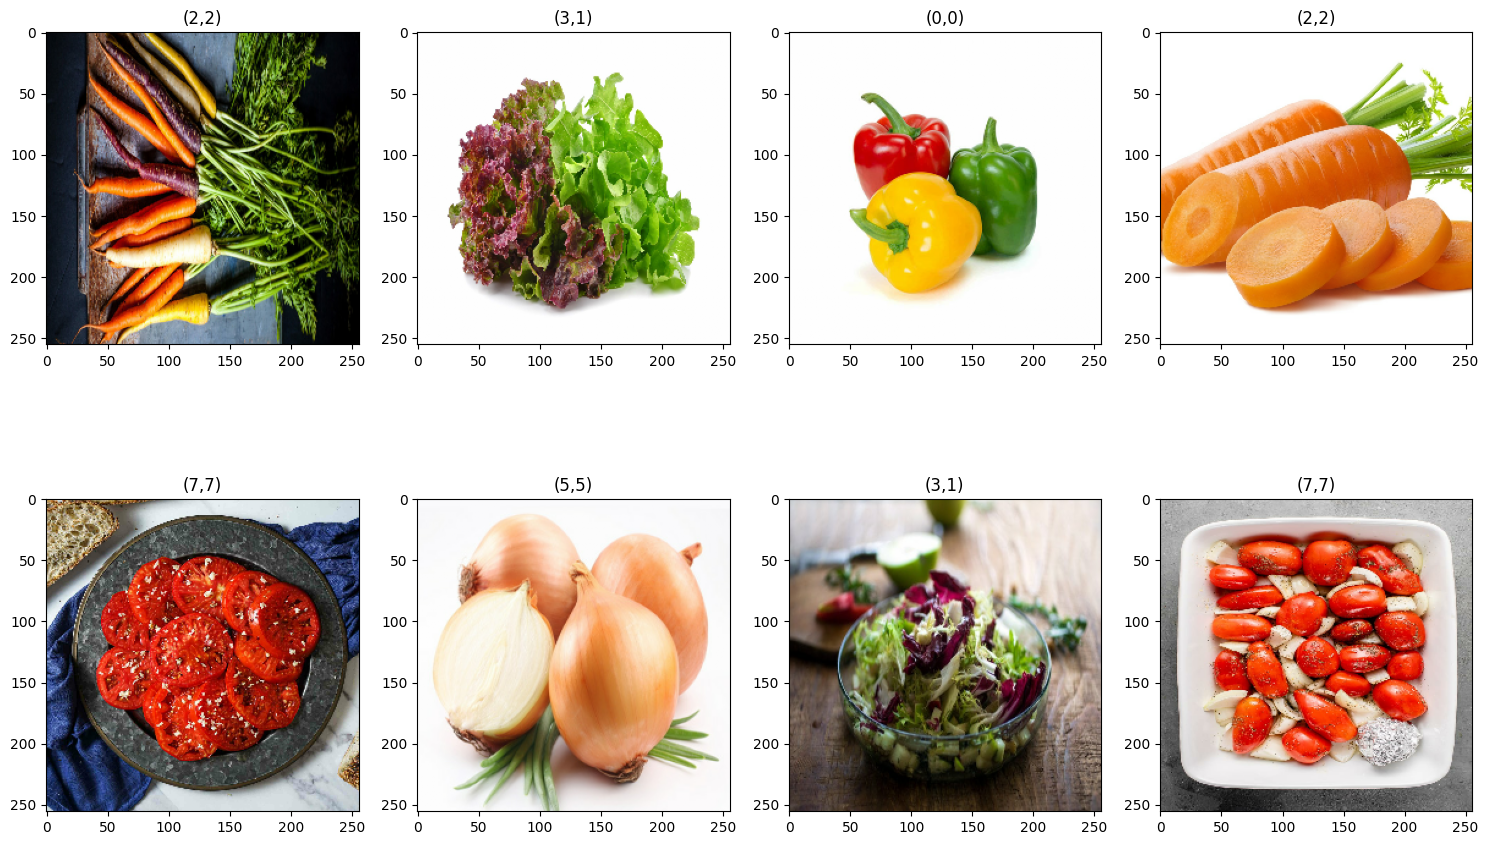

In [24]:
test_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/test/'
test = tf.keras.utils.image_dataset_from_directory(test_dir)
test = test.map(lambda x,y: (x/255.,y))
test_iterator = test.as_numpy_iterator()
batch = test_iterator.next()
X, y = batch
preds = model.predict(X)

n_plots = 8
plt.figure(figsize=(15, 10))
for idx, img in enumerate(X[:n_plots]):
    plt.subplot(2, n_plots//2, idx+1)
    plt.imshow(img)
    predicted_class = np.argmax(preds[idx])
    plt.title(f"({y[idx]},{predicted_class})")

plt.tight_layout()
plt.show()

In [20]:
from keras.metrics import Accuracy

predicted_labels = []
true_labels = []

accuracy = Accuracy()

for batch in test.as_numpy_iterator():
    X, y = batch

    preds_prob = model.predict(X)
    predictions = [np.argmax(i) for i in preds_prob]
    accuracy.update_state(y, predictions)

    true_labels += list(y)
    predicted_labels += predictions

1/1 [==============================] - 0s 370ms/step


In [25]:
print("Results for test data:")
print(f"Accuracy:  {accuracy.result().numpy():.2f}")

Results for test data:
Accuracy:  0.68


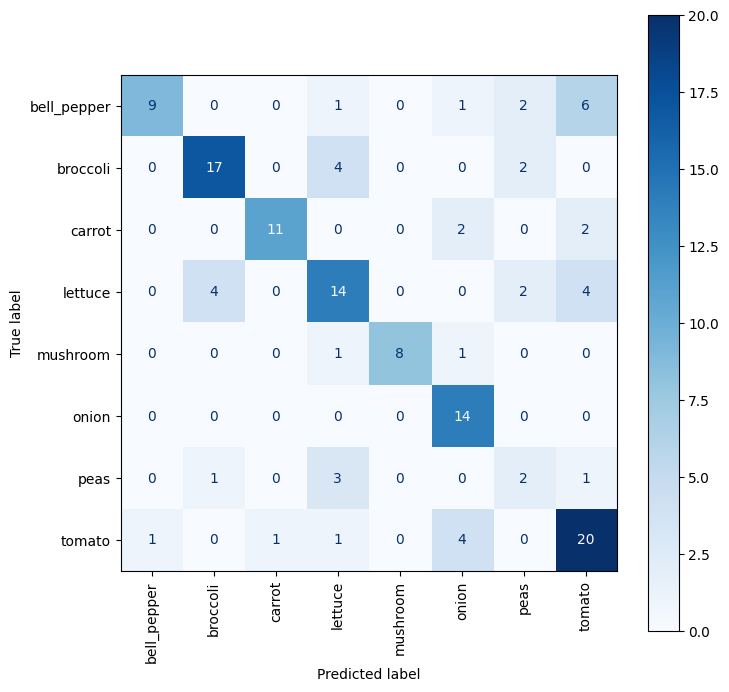

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


# predictions on test set

In [35]:
import cv2
img = cv2.imread('/content/drive/MyDrive/Projects/vegetable_identifier/new_test_images/carrot_test.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

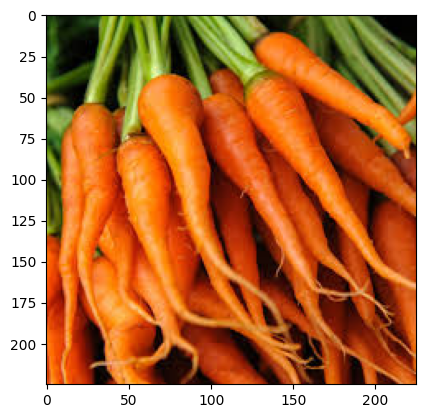

In [36]:
plt.imshow(img)
plt.show()

In [37]:
resize = tf.image.resize(img, (256,256))
predicted_probs = model.predict(np.expand_dims(resize/255, 0))
predicted_class = np.argmax(predicted_probs)
print(f"Predicted class is {categories[predicted_class]}")


1/1 [==============================] - 0s 64ms/step
Predicted class is carrot


# Save model

In [ ]:
from keras.models import load_model
model_name = 'VegNet_basicCNN'
model.save(os.path.join('/content/drive/MyDrive/Projects/vegetable_identifier/models',model_name))

In [ ]:
# To read in the model:
new_model = load_model(os.path.join('/content/drive/MyDrive/Projects/vegetable_identifier/models',model_name))

In [ ]:
# To run on new data:
img = cv2.imread('/content/drive/MyDrive/Projects/vegetable_identifier/test_images/carrot_test.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256))
predicted_probs = model.predict(np.expand_dims(resize/255, 0))
predicted_class = np.argmax(predicted_probs)
print(f"Predicted class is {categories[predicted_class]}")

1/1 [==============================] - 0s 37ms/step
Predicted class is carrot
